In [1]:
import sys
import numpy as np
sys.path.insert(0, '/home/david/Institut/rydanalysis/')
from rydanalysis import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from scipy import interpolate
mpl.rc('image', cmap='viridis')
sns.set_style("darkgrid")
from lmfit import Model,Parameters
import xarray as xr
import plotly.express as px

In [2]:
from scipy import ndimage

In [3]:
binning_scale=1

In [4]:
seq = ExpSequence("/home/david/Institut/2019_IEI_new/July/24/redscan")
#shot = SingleShot("/home/david/Institut/2019_IEI/July/02/scanblueresonance_FINAL_averaged_images/2019-06-05_00.fts")

In [5]:
variables= seq.variables.copy()
for i,shot in enumerate(seq.iter_single_shots()):
    try:
        image=shot.image
        absorb = calc_absorbtion_image(image)
        absorb = crop_image(absorb,xslice=slice(10,90),yslice=slice(10,380))
        od = absorbtion_to_OD(absorb)
        od = nn_replace_nonfinite(od,~np.isfinite(od))
        shot.optical_density = od
    except: pass

/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning:

divide by zero encountered in true_divide

/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:20: RuntimeWarning:

invalid value encountered in true_divide

/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:9: RuntimeWarning:

divide by zero encountered in log

/home/david/Institut/rydanalysis/rydanalysis/single_shot/image_processing.py:9: RuntimeWarning:

invalid value encountered in log



In [6]:
try:seq.analysis['plots']=Directory('plots')
except: pass
plotdir = seq.analysis['plots'].path

In [7]:
#od = ndimage.gaussian_filter(od, 4, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)

def fit2dGaussian(image):
    image = ndimage.gaussian_filter(image, 8, order=0, output=None, mode='constant', cval=0.0, truncate=4.0)
    fit = Fit2dGaussian(image)
    fit.params = fit.guess(image)
    #fit.params = restrict_to_init(fit.params,dev=0.2)
    #fit.params['amp'].max = fit.params['amp'].value*(1+0.5)
    #fit.params['amp'].min = fit.params['amp'].value*(1-0.5)
    #fit.params['cen_x'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_x'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['cen_y'].max = fit.params['amp'].value*(1+0.1)
    #fit.params['cen_y'].min = fit.params['amp'].value*(1-0.1)
    #fit.params['offset'].max = fit.params['amp'].value*(1+2)
    
    fit.params['offset'].vary = False
    fit.params['offset'].value = 0
    fit.params['amp'].min = 0
    fit.fit_data()
    return fittoSeries(fit)

In [8]:

def fit22dGaussian(image):
    model_twoG = Model(two_Gaussian)

    params = Parameters()

    params = model_twoG.make_params()



    # cloud distribution
    params.add('amp1',value=0.1)
    params.add('cen_y1',value=128*binning_scale,min=100*binning_scale,max=200*binning_scale)
    params.add('cen_x1',value=43*binning_scale,min=20*binning_scale,max=60*binning_scale)
    params.add('sig_x1',value=27*binning_scale,min=10*binning_scale,max=100*binning_scale)
    params.add('sig_y1',value=66*binning_scale,min=10*binning_scale,max=100*binning_scale)
    params.add('theta1',value=0,min=-np.pi/10,max=np.pi/10)

    # EIT/Autler-Townes-dip
    params.add('amp2',value=0.00,vary=True)
    params.add('cen_y2',value=150*binning_scale,min=140*binning_scale,max=160*binning_scale,vary=True)
    params.add('cen_x2',value=39*binning_scale,min=36*binning_scale,max=48*binning_scale,vary=True)
    params.add('sig_x2',value=5*binning_scale,min=3*binning_scale,max=8*binning_scale,vary=False)
    #params.add('sigma_y2',value=10,min=3,max=15)
    params.add('sig_y2',expr='sig_x2',vary=False)
    params.add('theta2',value=0.0000001,min=0,max=np.pi,vary=False)

    # offset
    params.add('offset',value=0.000001,vary=False)
    model = model_twoG
    
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    
    image_flat=image.flatten() 
    #weights_flat=image_weights.flatten()
    out = model.fit(image_flat,params,xy_mesh=(x,y))
    return out

In [38]:
def ThreeTwoTrans(Dp,Dp0,Dc,Dc0,g31,g21,Wc,k):
    """
    Imaginary Part of the first order susceptibility
    in the ladder scheme:
    index 1 ~ ground state
    index 2 ~ Rydberg state
    index 3 ~ intermediate state
    prefactor in units of MHz*m^3
    density is in units of 10^15 1/m^3
    detunings,rabi-frequencys and Decay rates in MHz
    """  
    Dp=Dp-Dp0
    Dc=Dc-Dc0
    d = Dp-Dc

    return (8* d**2 *g31+2*g21*(Wc**2 + g21*g31)) / abs(Wc**2 + (g31+1.j*2*Dp)*(g21+1.j*2*d))**2


    

In [10]:
def stderr_weighted_average(g):
    rel_err = g.amp.stderr/g.amp.value
    weights = 1/rel_err
    return (g.image_od * weights).sum()/weights.sum()

In [11]:
data = seq.variables.copy()

In [12]:
data['image_od'] = [shot.optical_density[0] for shot in seq.iter_single_shots()]

data['image_light'] = [shot.image[3] for shot in seq.iter_single_shots()]
data['image_atoms'] = [shot.image[1] for shot in seq.iter_single_shots()]
data['image_bg'] = [shot.image[5] for shot in seq.iter_single_shots()]

data['light'] = data.image_light-data.image_bg
data['atoms'] = data.image_atoms-data.image_bg
data['diff'] = data.light- data.atoms

In [13]:
fit_res = data['image_od'].apply(fit2dGaussian)
fit_res.to_csv('fit_res.csv')
fit_res[data.columns] = data
data = fit_res

Apply conditional filters to data set

plt.figure(figsize=(12,8))
sns.scatterplot(x=data.MWduration,y=data.amp.value,hue = data.amp.stderr,markers='O',hue_norm=(0,0.0010),ci='std')
sns.lineplot(x=data.MWduration,y=data.amp.value)
plt.ylabel("Fitted peak OD")
plt.savefig(os.path.join(plotdir,'peakOD_vs_MWduration_LZ2.svg'))

fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
for i,group in enumerate(data.groupby('MWduration')):
    sns.distplot(group[1].amp.value,bins=7,ax=ax.flatten()[i])

fig,ax=plt.subplots(nrows=4,ncols=4,figsize=(20,20))
for i,group in enumerate(data.groupby('MWduration')):
    sns.distplot(group[1].cen_y.value,bins=7,ax=ax.flatten()[i])

### Group by *MWduration*

## Fit EIT dip

fit = data.image_od.apply(fit22dGaussian)

fit_res = fit.apply(fittoSeries)

In [14]:
var = 'dDDSred'

In [15]:
mw_av = data.groupby(var)['image_od'].apply(np.mean)
fit = mw_av.apply(fit22dGaussian)
fit_res = fit.apply(fittoSeries)

In [24]:
fit_res['3lvl_center_od'] = fit.apply(lambda x: x.eval(xy_mesh =(x.params['cen_x2'].value,x.params['cen_y2'].value))[0])

fit_res['2lvl_center_od'] = fit_res['3lvl_center_od']-fit_res.amp2.value
fit_res['32ratio'] = fit_res['3lvl_center_od']/fit_res['2lvl_center_od']

fit_res['3lvl_center_od_std'] = fit.apply(lambda x: x.eval_uncertainty(xy_mesh =(x.params['cen_x2'].value,x.params['cen_y2'].value))[0])
fit_res['3lvl_center_od_std'] = np.sqrt(fit_res['3lvl_center_od_std']**2 + fit_res.amp2.value**2)

fit_res['32ratio_std'] = fit_res['32ratio'] * np.sqrt(fit_res['3lvl_center_od_std']**2 + fit_res['3lvl_center_od_std']**2)

fit_res['binning'] = pd.cut(fit_res['2lvl_center_od'],bins = np.linspace(0.1,0.3,30))
fit_res['binning0']=fit_res.binning.apply(lambda x: x.left)
#sns.scatterplot(y=fit_res["3vs2lvl_od"],x=fit_res["2lvl_center_od"],ax = ax)
#fit_res.plot(y="3vs2lvl_od",x="2lvl_center_od",style='o',ax = ax)
res = fit_res#[fit_res['32ratio'] <= 1]
out = pd.DataFrame()
out['32ratio'] = res.groupby('binning0')['32ratio'].mean()
out['std'] = res.groupby('binning0')['32ratio'].std()

In [62]:
model32 = Model(ThreeTwoTrans,independent_vars=['Dp'])
params32 = model32.make_params()
params32.add('g31',value=6.02,min=4,max=8,vary=False)
#params32.add('Dp',value=0,min=-1,max=1,vary=False)
params32.add('Dp0',value=0,min=-1,max=1,vary=False)
params32.add('g21',value=0.2,min=0,max=2,vary=False)
params32.add('Wc',value=2.6,vary=True)
params32.add('Dc',value=0.6,min=-2,max=2,vary=True)
params32.add('Dc0',value=0,min=-1,max=1,vary=False)
params32.add('k',value=0.4,min=-1,max=1,vary=True)

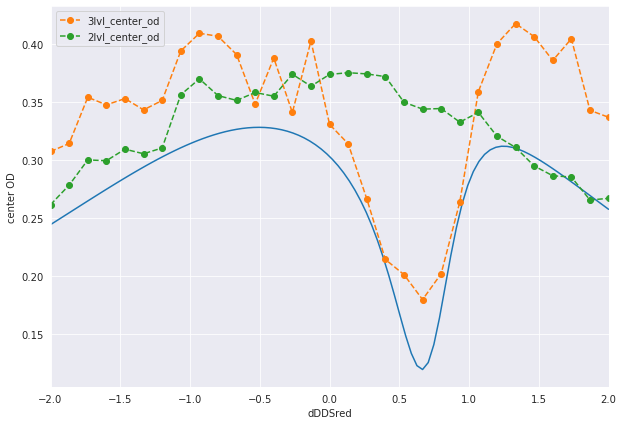

In [65]:
fig,ax = plt.subplots(figsize=(10,7))
#sns.scatterplot(data = res['3lvl_center_od'],ax=ax)
f=model32.fit(res['3lvl_center_od'].values,params=params32,Dp=res['3lvl_center_od'].index.values)
x = np.linspace(res.index.min(),res.index.max(),100)
ax.plot(x,model32.eval(Dp=x,params=f.params))
#ax.plot(x,model32.eval(Dp=x,params=params32))
res['3lvl_center_od'].plot(style='--o')
res['2lvl_center_od'].plot(style='--o') 
plt.ylabel('center OD')
plt.legend()
plt.savefig(os.path.join(plotdir,'OD_vs_{0}.pdf'.format(var)))


In [64]:
f.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Dc     0.6828       -2        2     None     True     None     None
Dc0         0       -1        1     None    False     None     None
Dp0         0       -1        1     None    False     None     None
Wc      1.449     -inf      inf     None     True     None     None
g21       0.2        0        2     None    False     None     None
g31      6.02        4        8     None    False     None     None
k         0.4       -1        1     None     True     None     None


In [ ]:
for f,im in zip(fit,mw_av):
    shape = im.shape
    fig,ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].imshow(im,cmap='viridis',vmin=0,vmax=0.45)
    ax[0].contour(f.best_fit.reshape(shape))
    ax[1].imshow(f.residual.reshape(shape), cmap='coolwarm',vmin=-0.1,vmax=0.1)